Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [34]:
NAME = "Jacopo Andreoli"
ID_number = int("2011655")

# Classification on Wine Dataset

### Dataset description

We will be working with a dataset on wines from the UCI machine learning repository
(http://archive.ics.uci.edu/ml/datasets/Wine ). It contains data for 178 instances. 
The dataset is the results of a chemical analysis of wines grown in the same region
in Italy but derived from three different cultivars. The analysis determined the
quantities of 13 constituents found in each of the three types of wines. 

### The features in the dataset are:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
-Proline




We first import all the packages that are needed

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

In [36]:
import random as rm

#the library is used into the function "choose_missclassified", the cell above the desription of perceptron algorithm
#successively, it is recall another time in the part of notebook is referred to logistic regression

In [37]:
np.random.seed(ID_number)

# Perceptron
We will implement the perceptron and use it to learn a halfspace with 0-1 loss.

Load the dataset from scikit learn and then split in training set and test set (50%-50%) after applying a random permutation to the datset.

In [38]:
# Load the dataset from scikit learn
wine = datasets.load_wine()
# Get input and output data from the dataset
X = wine.data
Y = wine.target
# Create new labels
Y = np.where(Y == 0, -1, Y)
Y = np.where(Y == 2, -1, Y)
# Let's get the number of features
d = X.shape[1]

In [39]:
##### Helper functions, do not modify them. You will need them for the first TODO
def check_constraints(labels, all_possibile_labels, min_num_istances):
    # Count the number of occurrences using numpy
    unique, counts = np.unique(labels, return_counts=True)
    if len(all_possibile_labels) != len(unique):
        return True
    if (counts >= min_num_istances).all():
        return False
    else:
        return True
    
def need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances): 
    return (check_constraints(y_train, all_possibile_labels, min_num_istances) or 
            check_constraints(y_test, all_possibile_labels, min_num_istances))

In [40]:
# TODO 1
# Write a function (create_train_val_test_datasets) which takes as input a dataset and returns 2 datasets: 
# S_t and S_test (different runs are supposed) to return different datasets.
# Write a function (create_train_val_test_datasets_with_constraints) which splits our data in S_t and S_test with 
# the additional constraint that in each dataset we MUST have more than min_num_istances per class.
# Each dataset is represented as a matrix m \times d (numpy ndarray), where m is the number of data and d is the 
# number of features.
# To solve this TODO use the functions we provide you: check_constraints and need_new_shuffle

def create_train_val_test_datasets(features : np.ndarray, labels: np.ndarray, m_t : int, m_test : int):
    '''
    Create training (S_t) and test (S_test) sets starting from a dataset. 
    This function shuffles the complete dataset before creating the subsets. 
    If you call this function twice it is expected to get different S_t, S_test. 
    
    :param features: NumPy ndarray containing all the input data data we can use
    :param labels: NumPy ndarray containing all the labels we have
    :param m_t: Number of samples for the training dataset
    :param m_test: Number of samples for the test dataset
    
    :returns: (x_train, y_train, x_test, y_test)
    :rtype: tuple
        WHERE
        x_train : np.ndarray features in the training dataset
        y_train : np.ndarray labels in the training dataset
        x_test : np.ndarray features in the test dataset
        y_test : np.ndarray labels in the test dataset
    '''
    # SUGGESTION: Use the function np.random.permutation (see the documentation) to create a permutation of the 
    #             dataset indexes. Then use these shuffled indexes to create S_t, S_val, S_test
    # YOUR CODE HERE
    x_train=np.zeros((m_t, features.shape[1]))
    y_train=np.zeros((m_t, 1))
    x_test=np.zeros((m_test, features.shape[1]))
    y_test=np.zeros((m_test, 1))
    random_array_1=np.random.permutation(np.arange(0,features.shape[0],1))
    j=0
    k=0
    for i in random_array_1[:m_t]:
        x_train[j]=features[i]
        y_train[j]=labels[i]
        j=j+1
    for u in random_array_1[m_t:m_t+m_test]:
        x_test[k]=features[u]
        y_test[k]=labels[u]
        k=k+1
    
    return x_train, y_train, x_test, y_test


def create_train_val_test_datasets_with_constraints(features : np.ndarray, labels: np.ndarray, m_t : int, 
                                                    m_test : int, min_num_istances : int):
    '''
    Same as function above but now we are imposing the constraints: the splitted datasets are assumed to contain 
    at least min_num_istances per class.
    
    ...
    :param min_num_istances: Minimum number of istances per class in each of the splitted datasets
    ...
    
    '''
    x_train, y_train, x_test, y_test=create_train_val_test_datasets(features, labels, m_t, m_test)
    all_possibile_labels = np.unique(labels) #rappresent the different value that we have, take one time
    while need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances):
        x_train, y_train, x_test, y_test=create_train_val_test_datasets(features, labels, m_t, m_test)
    return x_train, y_train, x_test, y_test

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

In [41]:
assert x_train.shape == (m_t,       x_train.shape[1]) # here we are comparing two tuples (it is an element wise comparison)
assert x_test.shape  == (len(Y)-m_t, x_test.shape[1])

In [42]:
# Let's add a 1 in fron of each sample so that we can use a vector to describe all the coefficients of the model.
# Do not run this celle multiple times otherwise you will continue adding ones... 
# (we add the assert to avoid such issue)

assert x_train.shape[1] == d
assert x_test.shape[1] == d 

x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

**TO DO 2** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where 1 iteration corresponds to 1 update of the perceptron weights. If the perceptron returns because the maximum number of iterations has been reached, you should return an appropriate model (the best seen along the iterations). 

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model


**Auxiliary functions**

In order to correclty complete the perceptron function it is warmly recommended to define some auxiliary functions ("*find_missclassified*" and "*choose_missclassified*"). 


"__find_missclassified__"
This function looks for missclassified data points in the dataset $X$.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $curr\_w$: the current value of the parameter vector *w*

The output value is:
- $missclassified\_indeces$: a numpy array cointaining all the missclassified indeces  


"__choose_missclassified__"
This function return one single index choosen from a array of indeces. If the array is empty it returns a non valid index: -1. 

The input parameters to pass are:
- $missclassified\_indeces$: numpy arrya containing missclassified indeces

The output value is:
- $index$: Integer (or np.int64) containing the choosen index


In [43]:
# TODO 2

def find_missclassified(X,Y,w):
    # Here you can use np.argwhere to find which model predictions are correct (this is faster than a for loop)
    # but be carefull on the dimensions of your predictions vector and Y vector.
    # YOUR CODE HERE
    #predictions=np.where(np.matmul(w, X.T)>=0, 1, -1)
    predictions=np.where(np.sign(np.matmul(w, X.T))==0, 1, np.sign(np.matmul(w, X.T)))
    missclassified_indeces=np.delete(np.argwhere((Y.T*predictions)-Y.T**2),0,1)
    return missclassified_indeces.reshape(-1,) #one-dimensional array

def choose_missclassified(missclassified_indeces):
    if(missclassified_indeces.shape[0] == 0):
        return -1
    else:
        index=int(rm.choice(missclassified_indeces))
    return index

def perceptron(X,Y,max_num_iterations): #X is a matrix, Y a vector 
    #INITIALIZATION
    curr_w = np.zeros(X.shape[1])   #initialization to zero for the first value of w
    best_w = curr_w
    num_samples = X.shape[0]        # #of row = # of sample; #columns = #characteristics
    best_error = num_samples+1      # max + 1 number of possible errors 
    
    missclassified_indeces = None   # You need to assign this variable o the proper value
    number_of_misclassified= None       # You need to assign this variable o the proper value
    missclassified_chosen = None     # You need to assign this variable o the proper value
    
    # YOUR CODE HERE
    missclassified_indeces = find_missclassified(X,Y,curr_w) 
    number_of_misclassified = missclassified_indeces.shape[0]  
    missclassified_chosen = choose_missclassified(missclassified_indeces)   
    num_iter = 1  
    while (num_iter<=max_num_iterations and missclassified_chosen!=-1): 
        # Update rule
    # YOUR CODE HERE 
        curr_w= curr_w +Y[missclassified_chosen]*X[missclassified_chosen] 
        # Update missclassified data points and choose a new missclassified data point
        # YOUR CODE HERE
        missclassified_indeces = find_missclassified(X,Y,curr_w)   
        number_of_misclassified = missclassified_indeces.shape[0]
        missclassified_chosen = choose_missclassified(missclassified_indeces)
        # Update (if necessary) the best error achieved together with the best parameter up to now
        # YOUR CODE HERE
        if(number_of_misclassified<best_error):
            best_error=number_of_misclassified
            best_w = curr_w
            
        num_iter = num_iter+1
    best_error=float(best_error)/float(num_samples)
    return best_w, best_error

In [44]:
index = choose_missclassified(np.array(list(range(100))))
assert type(index) == np.int64 or type(index) == int


In [45]:
#now run the perceptron for 100 iterations
w_found, training_error = perceptron(x_train, y_train, 100)
print("Training error with 100 iterations: " + str(training_error))

Training error with 100 iterations: 0.2375


In [46]:
# TODO 3 
# Write a function to compute the fraction of missclassified samples given two nd.array vectors of shape number of 
# data times 1 (column vectors)
def classification_loss(y_target : np.ndarray, predictions : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples given two vectors: true labels and predictions. 
    :param y_target: output labels
    :param predictions: predictions
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    missclassified_indeces=np.argwhere(np.not_equal(y_target,predictions))
    return missclassified_indeces.shape[0] / y_target.shape[0]

# Write a function to comptue the fraction of missclassified samples for a generic dataset given inputs, targets and 
# a vector w.
def compute_fraction_missclassified(X : np.ndarray, Y : np.ndarray, w : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: parameters of the model to be tested
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    predictions=np.sign((np.matmul(X,w.T).reshape(Y.shape[0],1)))
    fraction_missclass=classification_loss(Y, predictions)
    return fraction_missclass 

In [47]:
assert classification_loss(np.array([[1],[3]]), np.array([[1],[3]])) == 0
assert classification_loss(np.array([[1],[2]]), np.array([[1],[3]])) == 0.5
y_labels, y_predictions = np.random.choice(10, 1000000), np.random.choice(10, 1000000)
assert np.isclose(classification_loss(y_labels, y_predictions), 0.9, atol=0.01)
assert training_error == compute_fraction_missclassified(x_train, y_train, w_found)


We now use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (that is an estimate of the true loss).

In [48]:
print(f"Training Error for 100 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 100 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 100 iterations is 0.2375
Test Error for 100 iterations is 0.2755


In [49]:
#now run the perceptron for 10000 iterations
w_found, training_error = perceptron(x_train, y_train, 10000)
print(f"Training Error for 10000 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 10000 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 10000 iterations is 0.1875
Test Error for 10000 iterations is 0.2449


**TO DO 4**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider 100 iterations: what relation do you observe between the training error and the (estimated) true loss? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider 10000 iterations, what has changed? Explain what you observe and why it does or does not conform to your expectations.

YOUR ANSWER HERE

1- Yes, it is what i expected because we can observe that the estimated error for the test set is greater than the 
training error. This is the result of the evalution that we have done on our values of w take under consideration only
training data set. For this reason i expect that my prediction will fit better with the training dataset
       
2- with 10000 iterations we can see that our true error evaluated on the test dataset is more accurate because 
considering more step of the algorithm we converge to the linear classification, but without reach it.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We first do it for 2 labels and then for 3 labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [50]:
import random
# Let's reinitialize the random seed 
random.seed(ID_number)
np.random.seed(ID_number)

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it (have a look at the logreg.score method too).

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [51]:
x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

In [52]:
# TODO 5
# Logistic regression for 2 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# YOUR CODE HERE

logreg=linear_model.LogisticRegression(C=1e5, max_iter=10000) #logistic_regression model

logreg.fit(x_train, y_train.reshape(-1,),sample_weight=None)

logistic_regression_predictions_test=logreg.predict(x_test)
logistic_regression_predictions_train=logreg.predict(x_train)

error_rate_train=classification_loss(y_train, logistic_regression_predictions_train.reshape(80,1))

error_rate_test_sklearn=1-logreg.score(x_test, y_test)
error_rate_test=classification_loss(y_test, logistic_regression_predictions_test.reshape(98,1))

#evalutions of error
print("Error rate on training set with pereptron algorithm: "+str(error_rate_train))
print("Error rate on test set with perceptron algorithm: "+str(error_rate_test))
print(f"error test with the sklearn implementation of logistic regression {error_rate_test_sklearn}")

Error rate on training set with pereptron algorithm: 0.0
Error rate on test set with perceptron algorithm: 0.05102040816326531
error test with the sklearn implementation of logistic regression 0.05102040816326525


In [53]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

Now we do logistic regression for classification with 3 classes.

In [54]:
random.seed(ID_number)
np.random.seed(ID_number)

X = wine.data
Y = wine.target

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

_, counts = np.unique(y_train, return_counts=True)
assert (counts >= 20).all()
_, counts = np.unique(y_test, return_counts=True)
assert (counts >= 20).all()

In [55]:
x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

In [56]:
# TODO 6
# Logistic regression for 3 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# YOUR CODE HERE
logreg=linear_model.LogisticRegression(C=1e5, max_iter=10000) #logistic_regression model
logreg.fit(x_train, y_train.reshape(-1),sample_weight=None)
logistic_regression_predictions_test=logreg.predict(x_test)
logistic_regression_predictions_train=logreg.predict(x_train)
error_rate_test=classification_loss(y_test, logistic_regression_predictions_test.reshape(98,1))
error_rate_test_sklearn=1-logreg.score(x_test, y_test)
print(f"estimate of generalization test error with the sklearn implementation {error_rate_test_sklearn}")
print(f"estimate of generalization test error with the sklearn implementation {error_rate_test}")

estimate of generalization test error with the sklearn implementation 0.05102040816326525
estimate of generalization test error with the sklearn implementation 0.05102040816326531


In [57]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

**TO DO 7**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider logistic regression on 2 and 3 classes what relation do you observe between the training error and the (estimated) true loss in both cases? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider logistic regression on 2 and perceptron with 10000 iterations, which one would you pick? Do you expect perceptron needs more iterations? Explain what you observe and why it does or does not conform to your expectations.


We now are going to plot prediction boundaries of a logistic regression model, in order to plot them we need to reduce the number of features to 2: pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test.

In [58]:
# TODO 8
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                 'Proline']
labels_list = ['class_0', 'class_1', 'class_2']

index_feature1 = 0  # You can choose the feature you prefer here
index_feature2 = 1  # You can choose the feature you prefer here
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X = X[:,features]

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

# Fit a model on the reduced set of fetures
# YOUR CODE HERE
logreg=linear_model.LogisticRegression(C=1e5)
logistic_regression_w=logreg.fit(x_train, y_train.reshape(-1,),sample_weight=None)

In [59]:
assert logreg.predict(x_test).shape == (x_test.shape[0], )

The code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

Text(0.5, 1.0, 'Test set')

<Figure size 288x216 with 0 Axes>

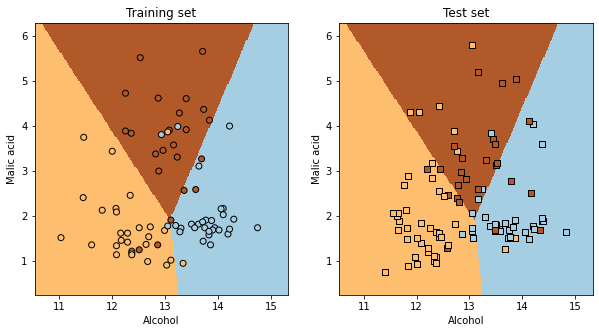

In [60]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
axes[0].set_xlabel(feature_name0)
axes[0].set_ylabel(feature_name1)

axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
axes[0].set_title('Training set')

# Put the result into a color plot
Z = Z.reshape(xx.shape)
axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
axes[1].set_xlabel(feature_name0)
axes[1].set_ylabel(feature_name1)

axes[1].set_xlim(xx.min(), xx.max())
axes[1].set_ylim(yy.min(), yy.max())
axes[1].set_title('Test set')

**TO DO 9**: Answer in the next cell (you do not need more than 5-7 lines):

1- What is the shape of the decision boundaries? Why?

2- In this lower dimensional space, are the features linearily separable? What if you consider the entire feature vector (without any dimensionality reduction)?  


YOUR ANSWER HERE

1- The shape of the decision boundaries can be seen like a set of straight lines that have the origin in common. 
   This is the consequence of using linear function in order to obtain the right classification.

2- Considering 3 class, we can see that the model that we can reconstruct using samples isn't linearly separable. However, we
   can have that what isn't linearly separable in three case, can be separable considering more dimensional parameters.
   
   